# TRGAN. Conditional Transaction Generation with differential privacy.
### Kirill Zakharov

1. [Data preprocessing](#data-preprocessing)
2. [Create embeddings](#create-embeddings)
3. [Train models](#train-trgan)
    1. [Time-dependent differential privacy](#time-dependent-differential-privacy)
    2. [TRGAN with differential private autoencoders](#trgan-with-differential-private-autoencoders)
    3. [TRGAN with RDP-GAN mechanism](#trgan-with-rdp-gan-mechanism)
    4. [DPGAN original](#original-dpgan)
    5. [TRGAN with DPGAN mechanism](#trgan-with-dpgan-mechanism)
    6. [PATE-GAN](#pate-gan)
4. [Evaluation](#synthetic-quality-and-privacy-preserving-evaluation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp
import scipy.stats as sts
from tqdm import tqdm
from sdv.metadata import SingleTableMetadata

from TRGAN.TRGAN_main import *
import TRGAN.Privacy_modules as privacy_trgan
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan_train
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
from TRGAN.dpgan import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
import matplotlib as mpl
#set params for the article
# mpl.rcParams['xtick.labelsize'] = 16
# mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['legend.fontsize'] = 14
# mpl.rcParams['axes.labelsize'] = 18

#set params for the notebook
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['axes.labelsize'] = 14

# Data preprocessing

### Import data

In [3]:
data = pd.read_csv('Data/data_raif_clean.csv')

### Filter data 

In [4]:
data = data[['transaction_date', 'customer', 'mcc', 'amount']]
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y-%m-%d')

In [5]:
data.head()

,transaction_date,customer,mcc,amount
0,2017-01-27,08d8e1f191c00d1d7ac1fd0bc9f5306d,6011,4.163806
1,2017-01-27,e40a8e2201ef64e9f9c833dcd7fcda61,6011,4.163903
2,2017-01-28,4cd5f6fba1b6058632181a17e54f9bd5,6011,2.785250
3,2017-01-28,1e1ca6794814c85f33c91e5c3d3468f6,6011,2.991422
4,2017-01-29,7f162c97c1c01b5651c815ba5ac218b3,6011,2.582697


In [6]:
data.shape

(146413, 4)

## Create embeddings

### Initialize all constants

In [7]:
'''
FEATURES NAMES
'''
cat_features = ['mcc']
cont_features = ['amount']
date_feature = ['transaction_date']
client_info = ['customer']

# data_cat = data[cat_features] 

'''
DIMENSIONS
'''
dim_X_cat = len(cat_features)
dim_cont_emb = 1
dim_X_cont = dim_cont_emb * len(cont_features)
dim_X_date = 4
dim_Xoh = 20 # dimension of X one hot embeddings
dim_Xcl = 4  # dimension of client's info embeddings
dim_Vc_h = 10 # dimension of conditional vector
dim_bce = 5 # dimension of the behaviour client encoding
dim_Vc = dim_Vc_h + dim_X_date
dim_X_emb = dim_Xoh + dim_X_cont + dim_Xcl
dim_noise = 25
# data_dim = len(data_transformed[0])

'''
LEARNING RATES
'''
lr_E_oh = 3e-4
lr_E_cl = 3e-4
lr_E_Vc = 3e-4
lr_E_cont = 3e-4

'''
SAVE DIRECTORY
'''
DIRECTORY = 'Pretrained_model/'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPSILON = 0.01
EPSILON_oh = 5

### Create OneHot representation of all categorical features $X_{oh}$ of dimension $d_{X_{oh}}$

In [8]:
experiment_id = 'Privacy_RAIF_1'
load = True

In [9]:
X_oh = onehot_emb_categorical(data, cat_features)

### Create embeddings of $X_{oh}$

In [10]:
X_oh_emb, encoder_onehot, decoder_onehot = trgan_train.create_cat_emb(X_oh, dim_Xoh, lr_E_oh, epochs=20,\
            batch_size=2**7, load=load, directory=DIRECTORY, names=[f'TRGAN_E_oh_exp_{experiment_id}.pkl',\
            f'TRGAN_D_oh_exp_{experiment_id}.pkl', f'X_oh_emb_exp_{experiment_id}.npy'], device=DEVICE, eps=EPSILON_oh)

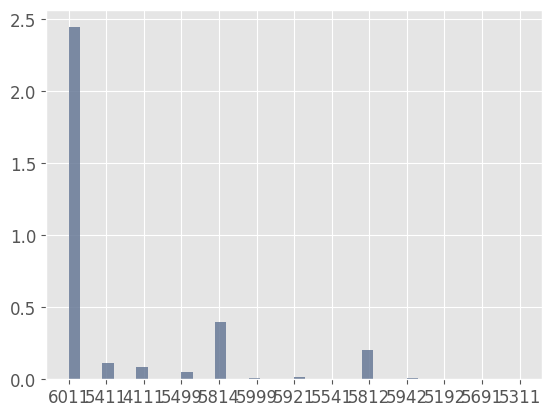

In [11]:
plt.hist(undummify(X_oh), bins=40, alpha=0.6, density=True)
plt.hist(undummify(pd.DataFrame(decoder_onehot(torch.FloatTensor(X_oh_emb).to(DEVICE)).detach().cpu().numpy(), columns=X_oh.columns)), bins=40, alpha=0.6, density=True)

plt.show()

### Create embeddings of the $X_{cont}$

In [12]:
X_cont, scaler_cont = trgan_train.create_cont_emb(dim_X_cont, data, cont_features, lr_E_cont, epochs=20, batch_size=2**7,\
            load=load, directory='Pretrained_model/', names=f'scaler_cont_{experiment_id}.npy', type_scale='CBNormalize', device=DEVICE, eps=EPSILON)

### Create embeddings of the $X_{cl}$

In [13]:
X_cl, encoder_cl_emb, decoder_cl_emb, scaler_cl_emb, label_encoders = trgan_train.create_client_emb(dim_Xcl, data, client_info,\
            dim_Xcl, lr_E_cl, epochs=20, batch_size=2**7, load=load, directory=DIRECTORY, names=[f'TRGAN_E_cl_{experiment_id}.pkl',\
            f'TRGAN_D_cl_{experiment_id}.pkl', f'X_cl_{experiment_id}.npy', f'scaler_{experiment_id}.joblib', f'label_enc_{experiment_id}.joblib'],\
            device=DEVICE, eps=EPSILON)

### Create embeddings $X_{emb}$

In [14]:
X_emb, scaler_emb = create_embeddings(X_cont, X_oh_emb, X_cl)

### Create conditional vector $v$

In [15]:
cond_vector, synth_time, date_transformations, behaviour_cl_enc, encoder, deltas_by_clients, synth_deltas_by_clients, xiP_array, idx_array =\
            trgan_train.create_conditional_vector(data, X_emb, date_feature, 'initial', dim_Vc_h, dim_bce, \
            name_client_id='customer', name_agg_feature='amount', lr_E_Vc=lr_E_Vc, epochs=15, batch_size=2**7, model_time='poisson', n_splits=4, load=load,\
            directory=DIRECTORY, names=[f'TRGAN_E_Vc_{experiment_id}.pkl', f'Vc_{experiment_id}.npy', f'BCE_{experiment_id}.npy'], opt_time=True,\
            device=DEVICE, eps=EPSILON)

In [16]:
print(f'Dim X_emb: {X_emb.shape} || Dim V_c: {cond_vector.shape}')

Dim X_emb: (146413, 25) || Dim V_c: (146413, 14)


## Train TRGAN

### Time-Dependent Differential Privacy

In [17]:
load=True

In [18]:
h_dim = 2**6
num_blocks_gen = 1
num_blocks_dis = 1
gauss_filter_dim = 20

if load:
    generator = privacy_trgan.Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)
    supervisor = privacy_trgan.Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)

    generator.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl'))
    supervisor.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl'))

    generator.eval()
    supervisor.eval()

    loss_array = np.load(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy')

else:
    generator, supervisor, loss_array, discriminator, discriminator2, epsilon_bar_array = privacy_trgan.train_generator(X_emb, cond_vector,\
                            dim_Vc, dim_X_emb, dim_noise, batch_size=2**8, lr_rates=[3e-4, 3e-4, 3e-4, 3e-4], num_epochs=30, num_blocks_gen=num_blocks_gen,\
                            num_blocks_dis=num_blocks_dis, h_dim=h_dim, lambda1=3, alpha=0.75, window_size=gauss_filter_dim, device=DEVICE,\
                            privacy_type='TDDP', eps=0.05)
    
    torch.save(generator.state_dict(), f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl')
    torch.save(supervisor.state_dict(), f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl')

    np.save(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy', loss_array)

    generator.eval()
    supervisor.eval()

In [19]:
# plt.subplots(figsize=(10, 5), dpi=100)

# plt.plot(epsilon_bar_array)

# plt.show()

### Loss functions

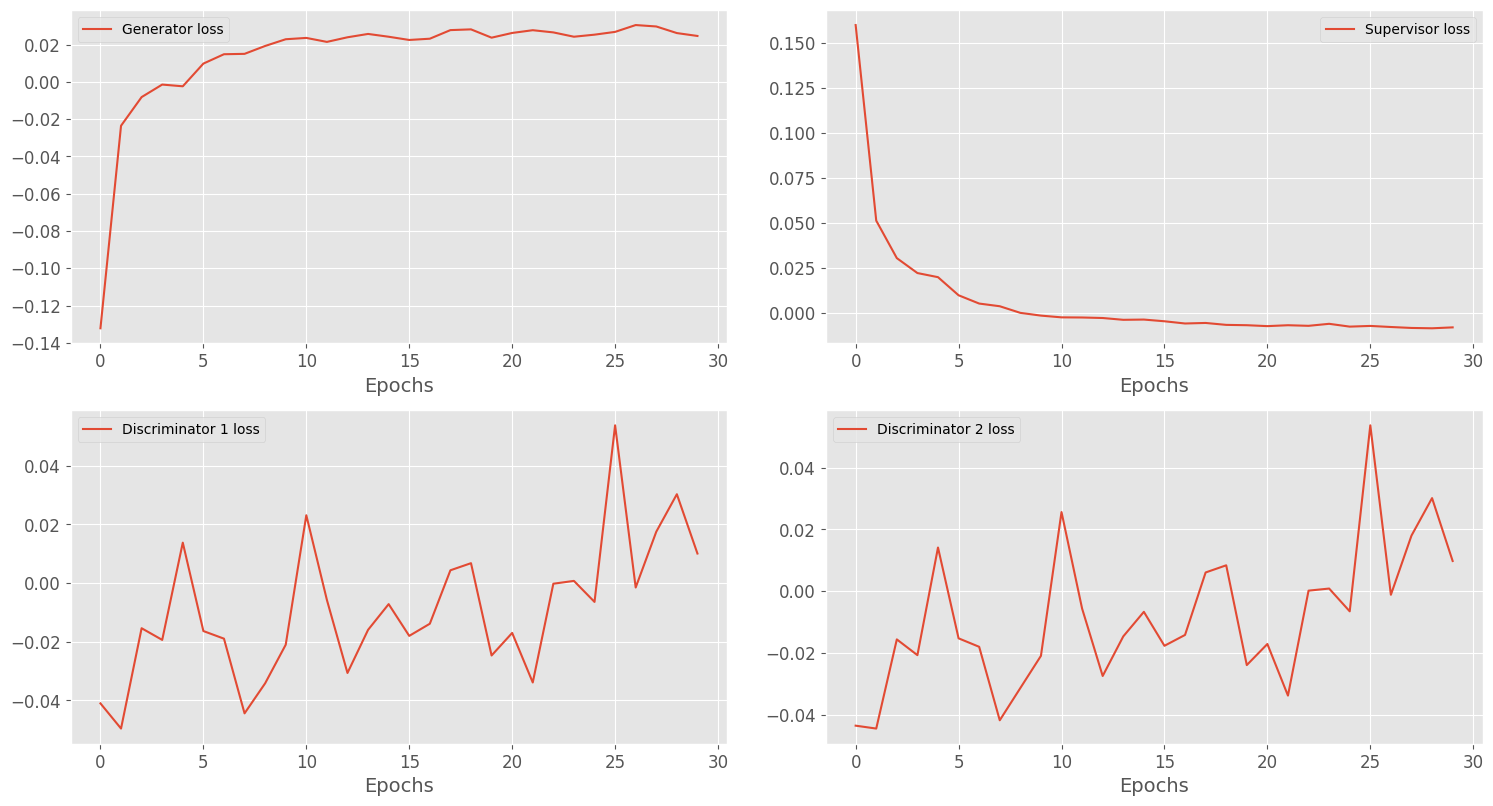

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=100)

axs[0, 0].plot(np.array(loss_array).T[2], label='Generator loss')
axs[0, 0].set_xlabel('Epochs')

axs[0, 1].plot(np.array(loss_array).T[3], label='Supervisor loss')
axs[0, 1].set_xlabel('Epochs')

axs[1, 0].plot(np.array(loss_array).T[0], label='Discriminator 1 loss')
axs[1, 0].set_xlabel('Epochs')

axs[1, 1].plot(np.array(loss_array).T[1], label='Discriminator 2 loss')
axs[1, 1].set_xlabel('Epochs')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
# plt.savefig('loss_TRGAN_TDDP.pdf', dpi=300)
plt.show()

In [21]:
from pytorch_model_summary import summary

print(summary(generator, torch.zeros((512, dim_noise+dim_Vc)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [512, 39]           2,560           2,560
       LeakyReLU-2           [512, 64]               0               0
       LayerNorm-3           [512, 64]             128             128
          Linear-4           [512, 64]           4,160           4,160
            ReLU-5           [512, 64]               0               0
         Dropout-6           [512, 64]               0               0
          Linear-7           [512, 64]           4,160           4,160
            ReLU-8           [512, 64]               0               0
         Dropout-9           [512, 64]               0               0
      LayerNorm-10           [512, 64]             128             128
         Linear-11           [512, 64]           1,625           1,625
           Tanh-12           [512, 25]               0               0
Total

### Generate synthetics

In [22]:
n_samples = len(X_emb)
synth_data, synth_time = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                date_feature, 'customer', time='initial', model_time='poisson', n_splits=4, opt_time=False,\
                                xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df, synth_df_cat = inverse_transforms(n_samples, synth_data, synth_time, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)

## Quality Assessment

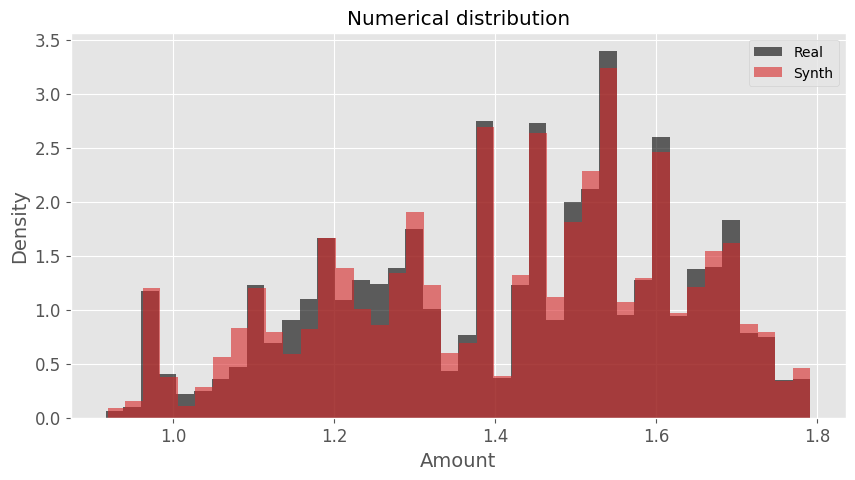

In [23]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, density=True, color='black')
plt.hist(np.log1p(abs(synth_df['amount'])), bins=40, label='Synth', alpha=0.6, density=True, color='tab:red')

plt.legend()
plt.title('Numerical distribution')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

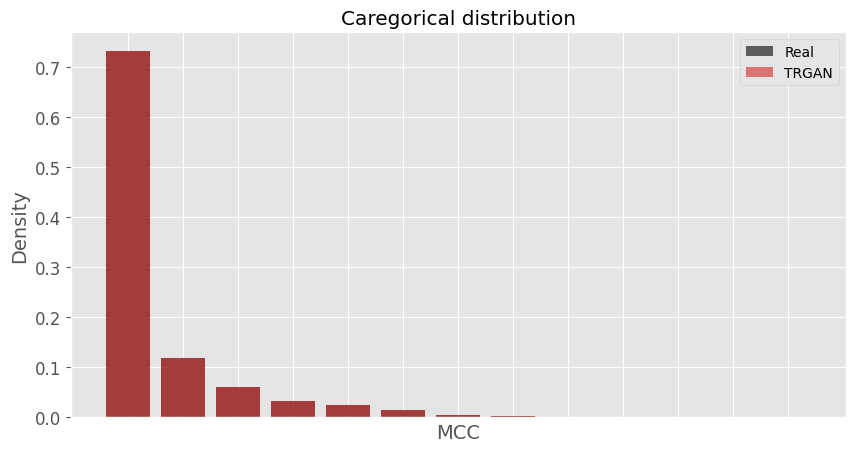

In [24]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().values/(np.sum(data['mcc'].value_counts().values)),\
                                                    color='black', alpha=0.6, label='Real')
plt.bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str), synth_df['mcc'].value_counts().values/(np.sum(synth_df['mcc'].value_counts().values)),\
                                                    color='tab:red', alpha=0.6, label='TRGAN')

# plt.xticks(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.legend()
plt.title('Caregorical distribution')
plt.ylabel('Density')
plt.xlabel('MCC')
plt.show()

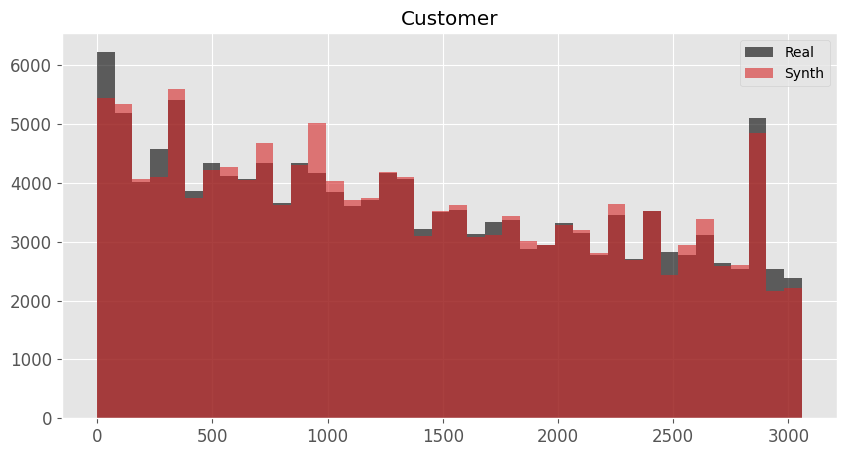

In [25]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(data['customer'], alpha=0.6, label='Real', bins=40, color='black')
plt.hist(synth_df['customer'], alpha=0.6, label='Synth', bins=40, color='tab:red')

plt.legend()
plt.xticks(np.arange(0, len(data['customer'].value_counts()), 500), np.arange(0, len(data['customer'].value_counts()), 500))
plt.title('Customer')

plt.show()

# Comparison with other models

### TRGAN with Differential Private Autoencoders

In [26]:
load=True

In [27]:
h_dim = 2**6
num_blocks_gen = 1
num_blocks_dis = 1
gauss_filter_dim = 20

if load:
    generator_ae = Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)
    supervisor_ae = Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)

    generator_ae.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_ae_exp_{experiment_id}.pkl'))
    supervisor_ae.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_ae_exp_{experiment_id}.pkl'))

    generator_ae.eval()
    supervisor_ae.eval()

    loss_array_ae = np.load(f'{DIRECTORY}loss_array_ae_{experiment_id}.npy')

else:
    generator_ae, supervisor_ae, loss_array_ae, _, _ = train_generator(X_emb, cond_vector,\
                            dim_Vc, dim_X_emb, dim_noise, batch_size=2**8, lr_rates=[3e-4, 3e-4, 3e-4, 3e-4], num_epochs=30, num_blocks_gen=num_blocks_gen,\
                            num_blocks_dis=num_blocks_dis, h_dim=h_dim, lambda1=3, alpha=0.8, window_size=gauss_filter_dim, device=DEVICE)
    
    torch.save(generator_ae.state_dict(), f'{DIRECTORY}TRGAN_generator_ae_exp_{experiment_id}.pkl')
    torch.save(supervisor_ae.state_dict(), f'{DIRECTORY}TRGAN_supervisor_ae_exp_{experiment_id}.pkl')

    np.save(f'{DIRECTORY}loss_array_ae_{experiment_id}.npy', loss_array_ae)

    generator_ae.eval()
    supervisor_ae.eval()

In [28]:
n_samples = len(X_emb)
synth_data_ae, synth_time_ae = sample(n_samples, generator_ae, supervisor_ae, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                date_feature, 'customer', time='initial', model_time='poisson', n_splits=4, opt_time=False,\
                                xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df_ae, _ = inverse_transforms(n_samples, synth_data_ae, synth_time_ae, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)

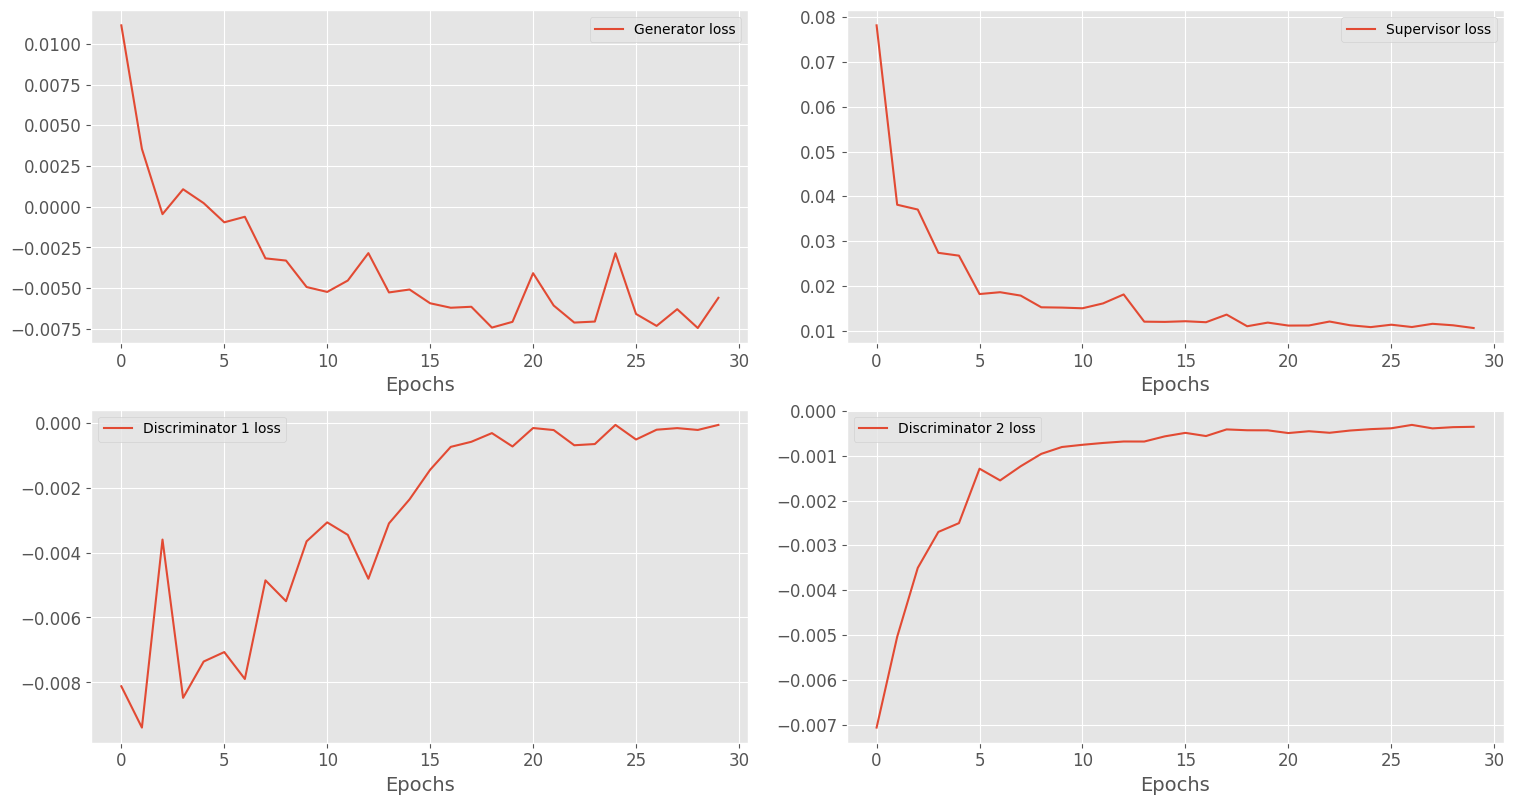

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=100)


axs[0, 0].plot(np.array(loss_array_ae).T[2], label='Generator loss')
axs[0, 0].set_xlabel('Epochs')

axs[0, 1].plot(np.array(loss_array_ae).T[3], label='Supervisor loss')
axs[0, 1].set_xlabel('Epochs')

axs[1, 0].plot(np.array(loss_array_ae).T[0], label='Discriminator 1 loss')
axs[1, 0].set_xlabel('Epochs')

axs[1, 1].plot(np.array(loss_array_ae).T[1], label='Discriminator 2 loss')
axs[1, 1].set_xlabel('Epochs')


axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
# plt.savefig('loss_TRGAN_AE.pdf', dpi=300)
plt.show()

### TRGAN with RDP-GAN mechanism

In [30]:
h_dim = 2**6
num_blocks_gen = 1
num_blocks_dis = 1
gauss_filter_dim = 20

if load:
    generator_rdp = privacy_trgan.Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)
    supervisor_rdp = privacy_trgan.Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen, gauss_filter_dim, DEVICE).to(DEVICE)

    generator_rdp.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_rdp_exp_{experiment_id}.pkl'))
    supervisor_rdp.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_rdp_exp_{experiment_id}.pkl'))

    generator_rdp.eval()
    supervisor_rdp.eval()

    loss_array_rdp = np.load(f'{DIRECTORY}loss_array_rdp_exp_{experiment_id}.npy')

else:
    generator_rdp, supervisor_rdp, loss_array_rdp, _, _, _ = privacy_trgan.train_generator(X_emb, cond_vector,\
                            dim_Vc, dim_X_emb, dim_noise, batch_size=2**8, lr_rates=[3e-4, 3e-4, 3e-4, 3e-4], num_epochs=30, num_blocks_gen=num_blocks_gen,\
                            num_blocks_dis=num_blocks_dis, h_dim=h_dim, lambda1=3, alpha=0.75, window_size=gauss_filter_dim, device=DEVICE,\
                            privacy_type='RDP', eps=0.05)
    
    torch.save(generator_rdp.state_dict(), f'{DIRECTORY}TRGAN_generator_rdp_exp_{experiment_id}.pkl')
    torch.save(supervisor_rdp.state_dict(), f'{DIRECTORY}TRGAN_supervisor_rdp_exp_{experiment_id}.pkl')

    np.save(f'{DIRECTORY}loss_array_rdp_exp_{experiment_id}.npy', loss_array_rdp)

    generator_rdp.eval()
    supervisor_rdp.eval()

In [31]:
n_samples = len(X_emb)
synth_data_rdp, synth_time_rdp = sample(n_samples, generator_rdp, supervisor_rdp, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                date_feature, 'customer', time='initial', model_time='poisson', n_splits=4, opt_time=False,\
                                xi_array=xiP_array, q_array=idx_array, device=DEVICE)

synth_df_rdp, synth_df_cat = inverse_transforms(n_samples, synth_data_rdp, synth_time_rdp, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)

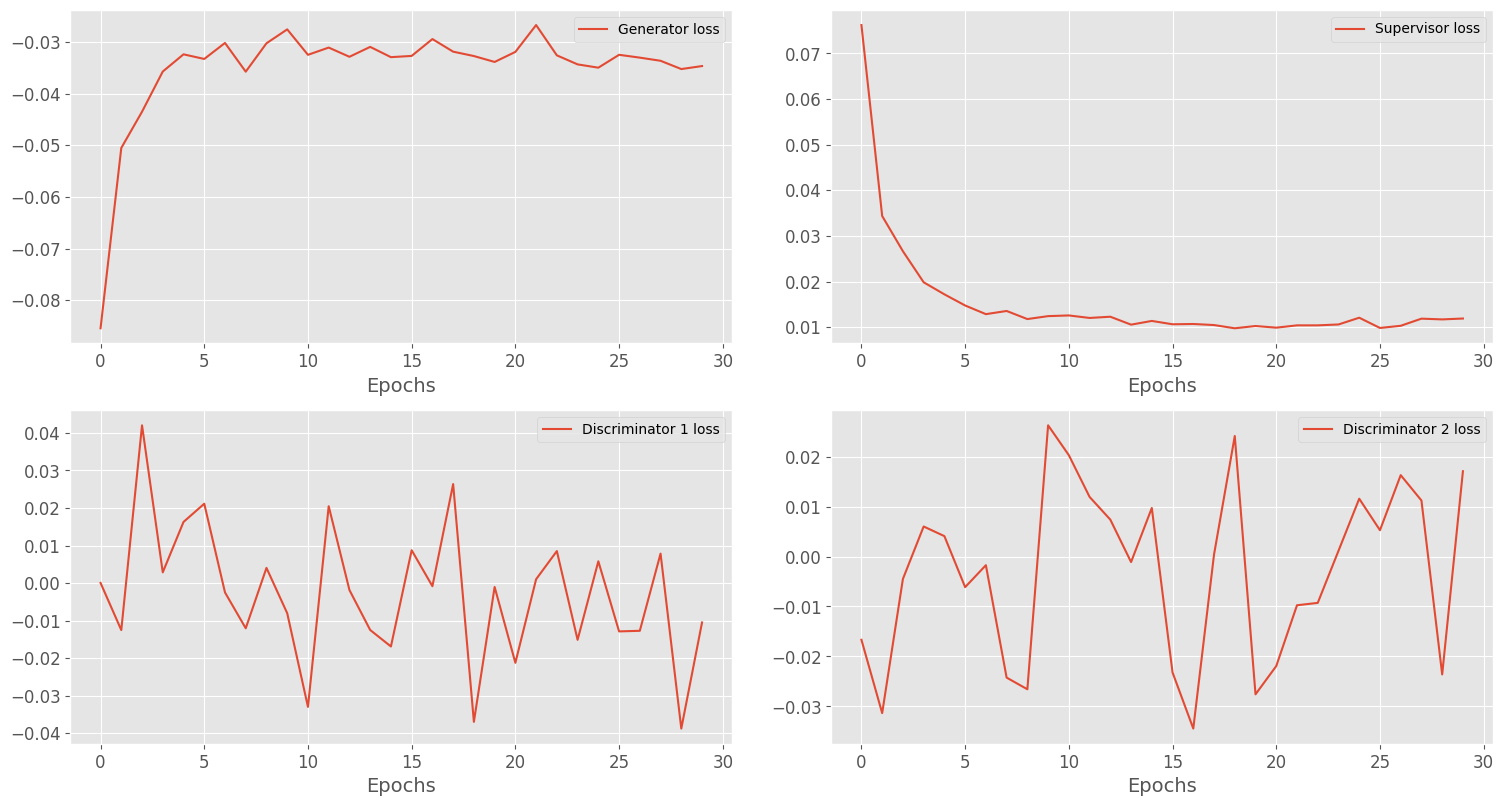

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=100)


axs[0, 0].plot(np.array(loss_array_rdp).T[2], label='Generator loss')
axs[0, 0].set_xlabel('Epochs')

axs[0, 1].plot(np.array(loss_array_rdp).T[3], label='Supervisor loss')
axs[0, 1].set_xlabel('Epochs')

axs[1, 0].plot(np.array(loss_array_rdp).T[0], label='Discriminator 1 loss')
axs[1, 0].set_xlabel('Epochs')

axs[1, 1].plot(np.array(loss_array_rdp).T[1], label='Discriminator 2 loss')
axs[1, 1].set_xlabel('Epochs')


axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
# plt.savefig('loss_TRGAN_RDPGAN.pdf', dpi=300)
plt.show()

### Original DPGAN

In [33]:
eps = 0.05

loss_array_dpgan, synth_df_dpgan = sample_dpgan(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, encoder, data, behaviour_cl_enc, date_feature, xiP_array,\
                idx_array, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, 'CBNormalize',
                'DPGAN', eps, load, DEVICE, DIRECTORY, experiment_id)

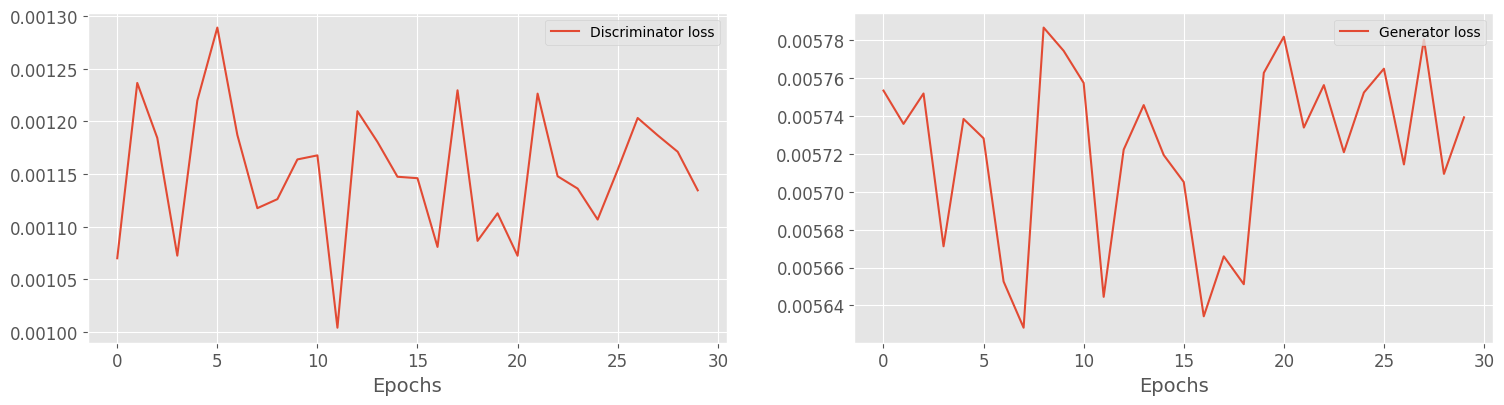

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(np.array(loss_array_dpgan).T[0], label='Discriminator loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(np.array(loss_array_dpgan).T[1], label='Generator loss')
axs[1].set_xlabel('Epochs')

axs[0].legend()
axs[1].legend(loc=1)

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.2)
# plt.savefig('loss_DPGAN.pdf', dpi=300)
plt.show()

### TRGAN with DPGAN mechanism

In [35]:
eps = 0.05

loss_array_trgan_dpgan, synth_df_trgan_dpgan = sample_trgan_dpgan(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, encoder, data, behaviour_cl_enc, date_feature, xiP_array,\
                idx_array, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, 'CBNormalize',
                'TRGAN_DPGAN', eps, load, DEVICE, DIRECTORY, experiment_id)

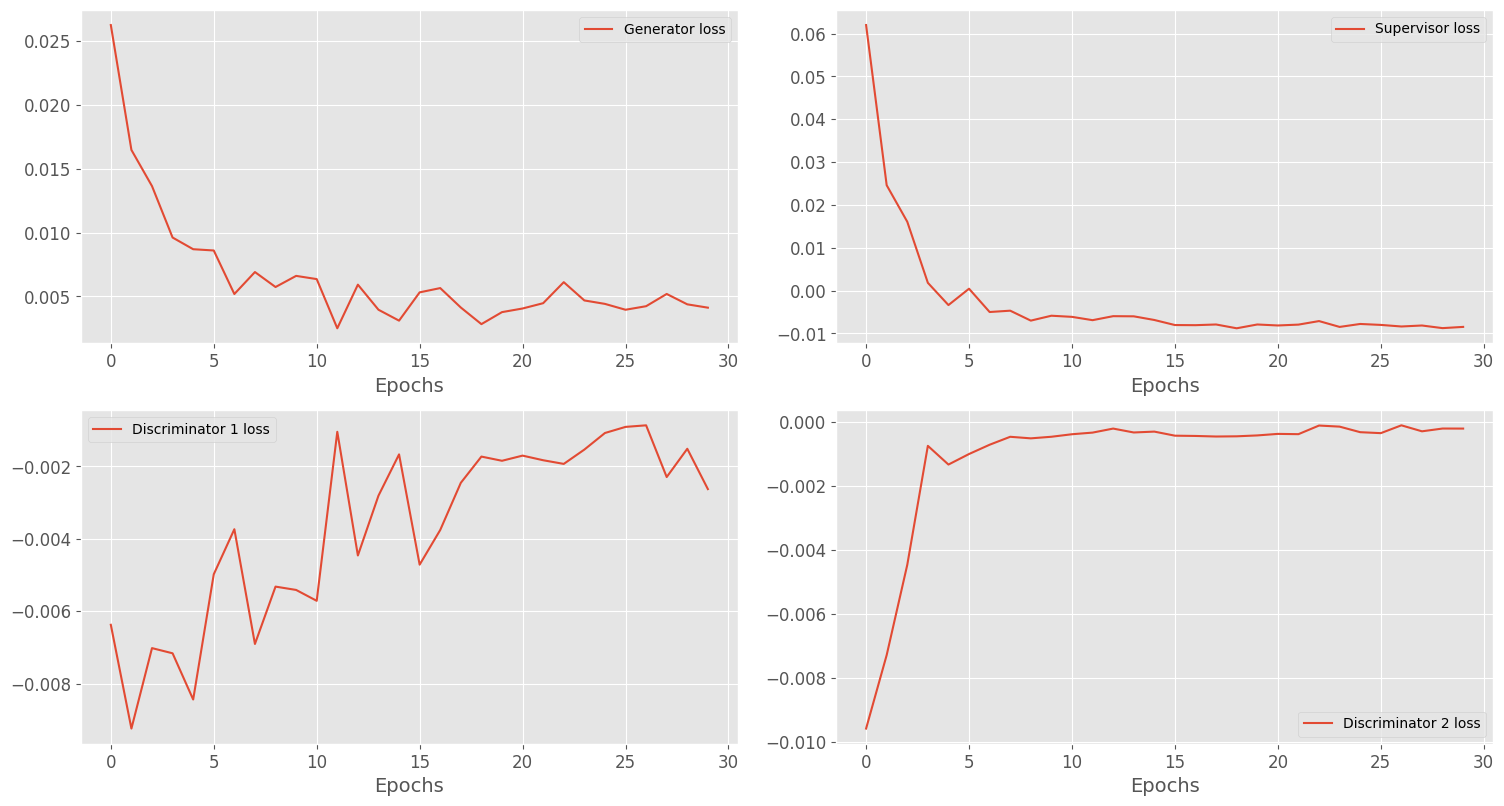

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), dpi=100)


axs[0, 0].plot(np.array(loss_array_trgan_dpgan).T[2], label='Generator loss')
axs[0, 0].set_xlabel('Epochs')

axs[0, 1].plot(np.array(loss_array_trgan_dpgan).T[3], label='Supervisor loss')
axs[0, 1].set_xlabel('Epochs')

axs[1, 0].plot(np.array(loss_array_trgan_dpgan).T[0], label='Discriminator 1 loss')
axs[1, 0].set_xlabel('Epochs')

axs[1, 1].plot(np.array(loss_array_trgan_dpgan).T[1], label='Discriminator 2 loss')
axs[1, 1].set_xlabel('Epochs')


axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
# plt.savefig('loss_TRGAN_DPGAN.pdf', dpi=300)
plt.show()

### PATE-GAN

In [37]:
eps = 0.05

loss_array_pategan, synth_df_pategan = sample_dpgan(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, encoder, data, behaviour_cl_enc, date_feature, xiP_array,\
                idx_array, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, 'CBNormalize',
                'PATEGAN', eps, load, DEVICE, DIRECTORY, experiment_id)

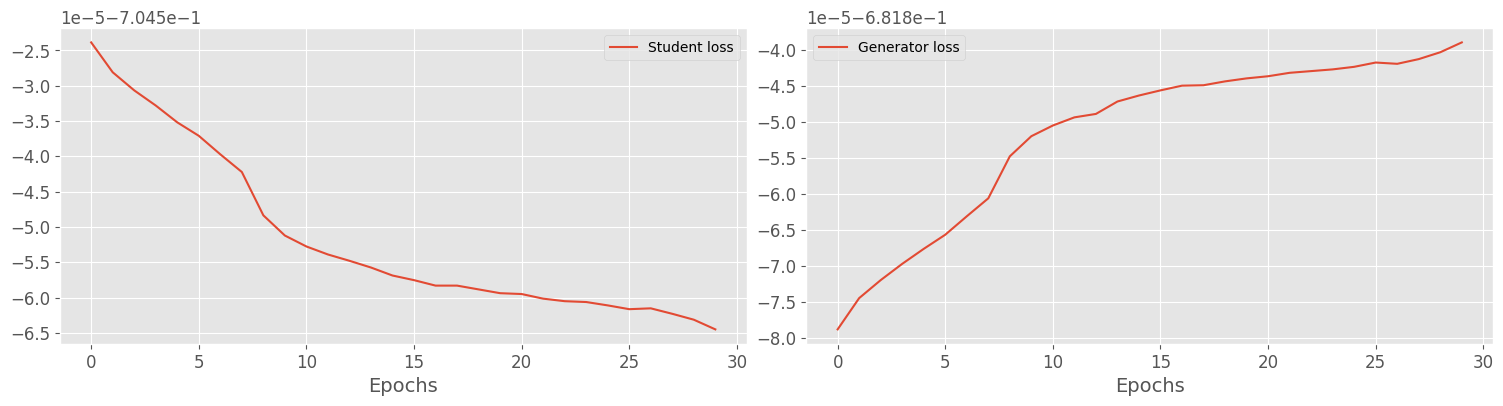

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(np.array(loss_array_pategan).T[0], label='Student loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(np.array(loss_array_pategan).T[1], label='Generator loss')
axs[1].set_xlabel('Epochs')

axs[0].legend()
axs[1].legend()

plt.tight_layout(pad=0.5)
# plt.savefig('loss_PATEGAN.pdf', dpi=300)
plt.show()

## Synthetic quality and Privacy preserving evaluation

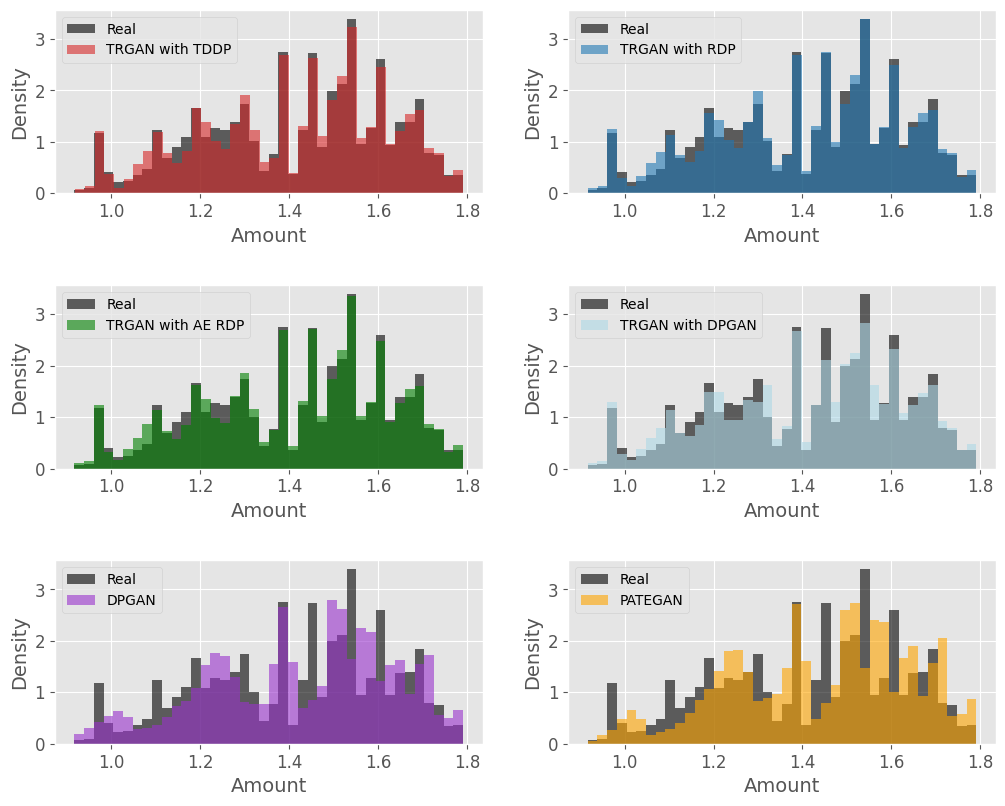

In [39]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=100)


axs[0, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[0, 0].hist(np.log1p(abs(synth_df['amount'])), bins=40, label='TRGAN with TDDP', alpha=0.6, color='tab:red', density=True)
axs[0, 0].set_xlabel('Amount')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

axs[0, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[0, 1].hist(np.log1p(abs(synth_df_rdp['amount'])), bins=40, label='TRGAN with RDP', alpha=0.6, color='tab:blue', density=True)
axs[0, 1].set_xlabel('Amount')
axs[0, 1].set_ylabel('Density')
axs[0, 1].legend()

axs[1, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[1, 0].hist(np.log1p(abs(synth_df_ae['amount'])), bins=40, label='TRGAN with AE RDP', alpha=0.6, color='green', density=True)
axs[1, 0].set_xlabel('Amount')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

axs[1, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[1, 1].hist(np.log1p(abs(synth_df_trgan_dpgan['amount'])), bins=40, label='TRGAN with DPGAN', alpha=0.6, color='lightblue', density=True)
axs[1, 1].set_xlabel('Amount')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

axs[2, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[2, 0].hist(np.log1p(abs(synth_df_dpgan['amount'])), bins=40, label='DPGAN', alpha=0.6, color='darkorchid', density=True)
axs[2, 0].set_xlabel('Amount')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

axs[2, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[2, 1].hist(np.log1p(abs(synth_df_pategan['amount'])), bins=40, label='PATEGAN', alpha=0.6, color='orange', density=True)
axs[2, 1].set_xlabel('Amount')
axs[2, 1].set_ylabel('Density')
axs[2, 1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.50, wspace=0.20)
# plt.savefig('privacy_amount.pdf', dpi=300)
plt.show()

In [40]:
evaluate_numerical([data['amount'], synth_df['amount'], synth_df_rdp['amount'], synth_df_ae['amount'],\
                    synth_df_trgan_dpgan['amount'], synth_df_dpgan['amount'], synth_df_pategan['amount']],\
                    ['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,3.202157,0.832387,-0.951807,-0.028051,0.000000,0.000000,0.000000
TRGAN with TDDP,3.201506,0.837583,-0.928438,-0.024602,0.001889,0.012595,0.010123
TRGAN with RDP-GAN,3.198695,0.838340,-0.923691,-0.028836,0.002004,0.013585,0.010443
TRGAN with DP AE,3.197348,0.840535,-0.928744,-0.031042,0.002255,0.016488,0.011299
TRGAN with DPGAN,3.201845,0.843631,-0.927210,-0.034201,0.002461,0.019575,0.014400
DPGAN,3.253634,0.839031,-0.878100,-0.040589,0.005261,0.048479,0.057739
PATEGAN,3.306220,0.830653,-0.890715,-0.026878,0.005948,0.072056,0.104152


In [41]:
contig_cols = ['customer', 'mcc']

evaluate_categorical([data['mcc'], synth_df['mcc'], synth_df_rdp['mcc'], synth_df_ae['mcc'],\
        synth_df_trgan_dpgan['mcc'], synth_df_dpgan['mcc'], synth_df_pategan['mcc']],\
        index=['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'],\
        data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_df_rdp[contig_cols],\
        synth_df_ae[contig_cols], synth_df_trgan_dpgan[contig_cols], synth_df_dpgan[contig_cols], synth_df_pategan[contig_cols]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,13.0,0.000000
TRGAN with TDDP,0.999932,0.684734,13.0,0.000419
TRGAN with RDP-GAN,1.000000,0.682740,13.0,0.000000
TRGAN with DP AE,0.999966,0.683560,13.0,0.000163
TRGAN with DPGAN,0.998354,0.679899,13.0,0.001711
DPGAN,0.499628,0.278117,13.0,0.052058
PATEGAN,0.485169,0.244521,13.0,0.058146


In [42]:
evaluate_utility([data, synth_df, synth_df_rdp, synth_df_ae, synth_df_trgan_dpgan, synth_df_dpgan, synth_df_pategan],\
                ['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'], 5)

,F_1,Recall,AUC
Real,0.753086,0.772152,0.962864
TRGAN with TDDP,0.511211,0.407143,0.820389
TRGAN with RDP-GAN,0.539326,0.436364,0.839730
TRGAN with DP AE,0.478555,0.363014,0.816196
TRGAN with DPGAN,0.389873,0.267361,0.823218
DPGAN,0.622699,0.581662,0.857207
PATEGAN,0.394958,0.314732,0.702425


In [43]:
# metadata = SingleTableMetadata()
# metadata.add_column(
#     column_name='amount',
#     sdtype='numerical',
#     computer_representation='Float')

# metadata.add_column(
#     column_name='mcc',
#     sdtype='categorical')


# metadata.add_column(
#     column_name='customer',
#     sdtype='categorical')


# metadata.add_column(
#     column_name='transaction_date',
#     sdtype='datetime',
#     datetime_format='%Y %m %d')


# evaluate_new_rows([data, synth_df, synth_df_rdp, synth_df_ae, synth_df_trgan_dpgan, synth_df_dpgan, synth_df_pategan],\
#     ['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'], metadata)

In [69]:
distance_between_rows([data['amount'], synth_df['amount'], synth_df_rdp['amount'], synth_df_ae['amount'],\
    synth_df_trgan_dpgan['amount'], synth_df_dpgan['amount'], synth_df_pategan['amount']],\
    ['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'])

,MSE
Real,0.000000
TRGAN with TDDP,0.016230
TRGAN with RDP-GAN,0.016291
TRGAN with DP AE,0.016373
TRGAN with DPGAN,0.017448
DPGAN,0.062294
PATEGAN,0.049739


In [44]:
quasi_id = ['customer']

In [45]:
pd.DataFrame(np.array([[k_anonymity(data, quasi_id, 'mcc'), k_anonymity(synth_df, quasi_id, 'mcc'), k_anonymity(synth_df_rdp, quasi_id, 'mcc'),\
                        k_anonymity(synth_df_ae, quasi_id, 'mcc'), k_anonymity(synth_df_trgan_dpgan, quasi_id, 'mcc'), k_anonymity(synth_df_dpgan, quasi_id, 'mcc'),\
                        k_anonymity(synth_df_pategan, quasi_id, 'mcc')],\
                        [l_diversity(data, quasi_id, 'mcc'), l_diversity(synth_df, quasi_id, 'mcc'), l_diversity(synth_df_rdp, quasi_id, 'mcc'),
                         l_diversity(synth_df_ae, quasi_id, 'mcc'), l_diversity(synth_df_trgan_dpgan, quasi_id, 'mcc'), l_diversity(synth_df_dpgan, quasi_id, 'mcc'),
                         l_diversity(synth_df_pategan, quasi_id, 'mcc')],\
                        [t_closeness(data, quasi_id, 'amount'), t_closeness(synth_df, quasi_id, 'amount'), t_closeness(synth_df_rdp, quasi_id, 'amount'),\
                        t_closeness(synth_df_ae, quasi_id, 'amount'), t_closeness(synth_df_trgan_dpgan, quasi_id, 'amount'), t_closeness(synth_df_dpgan, quasi_id, 'amount'),
                        t_closeness(synth_df_pategan, quasi_id, 'amount')]]).T,\
                        # [l_diversity_cont(data, quasi_id, 'amount'), l_diversity_cont(synth_df, quasi_id, 'amount'), l_diversity_cont(synth_df_dpgan, quasi_id, 'amount')]]).T,\
            columns=['k-anonymity', 'l-diversity', 't-closeness'], index=['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE',\
            'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'])

In [42]:
amount_tddp = []
for i in range(40):
    n_samples = len(X_emb)
    synth_data, synth_time = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                    date_feature, 'customer', time='initial', model_time='poisson', n_splits=4, opt_time=False,\
                                    xi_array=xiP_array, q_array=idx_array, device=DEVICE)

    synth_df, synth_df_cat = inverse_transforms(n_samples, synth_data, synth_time, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                        label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)
    
    amount_tddp.append(synth_df['amount'].values)

In [97]:
amount_ae = []
for i in range(100):
    n_samples = len(X_emb)
    synth_data_ae, synth_time_ae = sample(n_samples, generator_ae, supervisor_ae, dim_noise, cond_vector, X_emb, encoder, data, behaviour_cl_enc,\
                                date_feature, 'customer', time='initial', model_time='poisson', n_splits=4, opt_time=False,\
                                xi_array=xiP_array, q_array=idx_array, device=DEVICE)

    synth_df_ae, _ = inverse_transforms(n_samples, synth_data_ae, synth_time_ae, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize', device=DEVICE)
    amount_ae.append(synth_df_ae['amount'].values)

In [98]:
js_amount_tddp = list(map(lambda x: jensenshannon(x, data.amount.values), np.array(amount_tddp)))
js_amount_ae = list(map(lambda x: jensenshannon(x, data.amount.values), np.array(amount_ae)))

In [99]:
from sklearn.neighbors import KernelDensity

In [100]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(np.array(js_amount_tddp).reshape(-1, 1))
x_test = np.linspace(-1, 1, 1000)
kde_tddp = kde.score_samples(np.array(x_test).reshape(-1, 1))

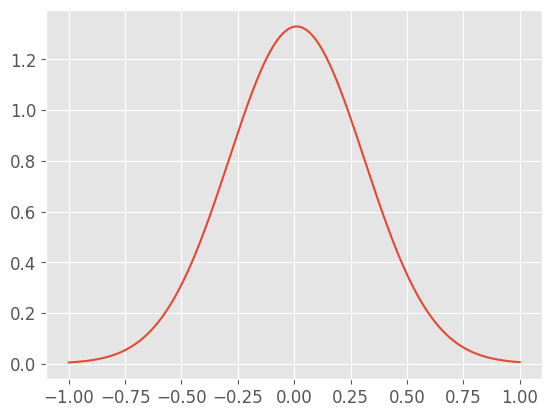

In [101]:
plt.plot(x_test, np.exp(kde_tddp))

plt.show()

In [102]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(np.array(js_amount_ae).reshape(-1, 1))
x_test = np.linspace(-1, 1, 1000)
kde_ae = kde.score_samples(np.array(x_test).reshape(-1, 1))

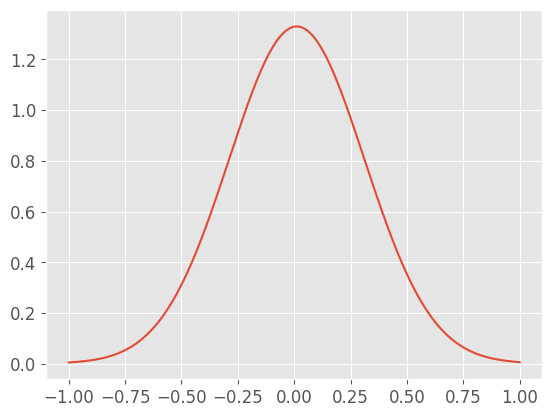

In [103]:
plt.plot(x_test, np.exp(kde_ae))

plt.show()